## Step one: Setup and create your dataset

First we need to create the Dataset in which we are going to store ou Machine Learning Model

In [8]:
PROJECT_ID= 'fourth-blend-336210'

from google.cloud import bigquery
client= bigquery.Client(project= PROJECT_ID, location="US")
dataset=client.create_dataset('bqml_tutorial', exists_ok=True)

In [9]:
# create a reference to our table
table = client.get_table("bigquery-public-data.google_analytics_sample.ga_sessions_*")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,NaN,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,NaN,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


Lets check the schema of our table 

In [ ]:
table.schema

Lets get some **informations** on our table 

In [16]:
# create a small sample dataframe
sample_table = client.list_rows(table, max_results=5).to_dataframe()

# get the first cell in the "totals" column
sample_table.totals[0]

{'visits': 1,
 'hits': 1,
 'pageviews': 1,
 'timeOnSite': None,
 'bounces': 1,
 'transactions': None,
 'transactionRevenue': None,
 'newVisits': 1.0,
 'screenviews': None,
 'uniqueScreenviews': None,
 'timeOnScreen': None,
 'totalTransactionRevenue': None,
 'sessionQualityDim': 1}

## Step two: Create your model
Next, we will create a logistic regression model for classifcation 

In [18]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [22]:
%%bigquery
CREATE MODEL IF NOT EXISTS `bqml_tutorial.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1990.65query/s]                        


""


## Step three: Get training statistics
To see the results of the model training, you can use the ML.TRAINING_INFO function, or you can view the statistics in the BigQuery UI. In this tutorial, you use the ML.TRAINING_INFO function.


In [23]:
%%bigquery

SELECT * FROM ML.TRAINING_INFO(MODEL `bqml_tutorial.sample_model`)
ORDER BY iteration

Downloading: 100%|██████████| 9/9 [00:02<00:00,  4.44rows/s]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.521573,0.521380,0.2,9145
1,0,1,0.320692,0.320174,0.4,10711
2,0,2,0.169802,0.168849,0.8,12923
3,0,3,0.097545,0.096203,1.6,11551
4,0,4,0.067776,0.066406,3.2,12300
5,0,5,0.053888,0.053337,6.4,11615
6,0,6,0.047345,0.048273,12.8,13219
7,0,7,0.044654,0.045499,25.6,13206
8,0,8,0.043878,0.045445,25.6,12367


At this point you'll notice that BQML has taken care of some of the common ML decisions for you:

- Splitting into training & evaluation datasets to help detect overfitting
- Early stopping (stopping training when additional iterations would not improve performance on the evaluation set)
- Picking and updating learning rates (starting with a low learning rate and increasing it over time)
- Picking an optimization strategy (batch gradient descent for large datasets with high cardinality, normal equation for small datasets where it would be faster)

## Step four: Evaluate the Model

A classifier is one of a set of enumerated target values for a label. For example, in this tutorial you are using a binary classification model that detects transactions. The two classes are the values in the label column: 0 (no transactions) and not 1 (transaction made).

To run the ML.EVALUATE query that evaluates the model, we will do the following: 


In [24]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IF(totals.transactions IS NULL, 0, 1) AS label,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(geoNetwork.country, "") AS country,
    IFNULL(totals.pageviews, 0) AS pageviews
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.41s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.468504,0.110801,0.985343,0.179217,0.046242,0.981743


Let's plot the **roc** curve to get a better idea on our model performance 

In [25]:
%%bigquery roc
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `bqml_tutorial.sample_model`)

Downloading: 100%|██████████| 90/90 [00:01<00:00, 66.58rows/s]


In [26]:
roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.008197,0.000000,1,0,9992,121
1,0.252477,0.319672,0.006605,39,66,9926,83
2,0.101970,0.549180,0.013811,67,138,9854,55
3,0.059840,0.696721,0.022718,85,227,9765,37
4,0.044989,0.819672,0.030725,100,307,9685,22


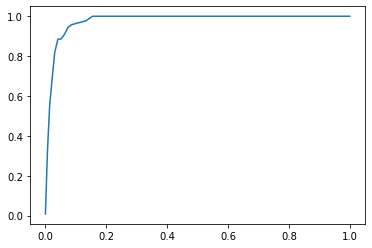

In [27]:
# and plot our ROC curve!
import matplotlib.pyplot as plt

# plot the false positive rate by true postive rate (aka recall)
plt.plot(roc.false_positive_rate, roc.recall)

In [32]:
%%bigquery
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY country
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

Downloading: 100%|██████████| 10/10 [00:00<00:00, 10.01rows/s]


,country,total_predicted_purchases
0,United States,220
1,Taiwan,8
2,Canada,7
3,India,2
4,Turkey,2
5,Japan,2
6,Serbia,1
7,Germany,1
8,Singapore,1
9,Brazil,1


In [31]:
predict_df.columns

Index(['predicted_label', 'predicted_label_probs', 'os', 'is_mobile',
       'pageviews', 'country'],
      dtype='object')

In the next example, we try to predict the number of transactions each website visitor will make. This query is identical to the previous query except for the GROUP BY clause. Here the GROUP BY clause — GROUP BY fullVisitorId — is used to group the results by visitor ID.

To run the query that predicts purchases per user:

In [33]:
%%bigquery
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY fullVisitorId
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  8.06rows/s]


,fullVisitorId,total_predicted_purchases
0,9417857471295131045,4
1,0376394056092189113,2
2,2969418676126258798,2
3,057693500927581077,2
4,2105122376016897629,2
5,0456807427403774085,2
6,7420300501523012460,2
7,489038402765684003,2
8,1280993661204347450,2
9,8064625150033508396,2
